In [2]:
cd /home/dmoi/projects/foldtree2

/home/dmoi/projects/foldtree2


In [ ]:
import torch
from src.pdbgraph import PDB2PyG
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example PDB file path
pdb_path = './config/1eei.pdb'

# Initialize parser
pdb2pyg = PDB2PyG(aapropcsv = './config/aaindex1.csv')

# Extract coordinates for N, CA, C atoms (shape: N, 3, 3)
coords = torch.stack([
	pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="N"),
	pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="CA"),
	pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="C"),
], dim=1)

# Compute R (rotation matrices) and T (translations)
R_true, t_true = pdb2pyg.compute_local_frame(coords)

In [ ]:
import numpy as np

def rotation_matrix_to_quaternion(R):
	"""
	Convert a batch of 3x3 rotation matrices to quaternions (x, y, z, w).
	R: (N, 3, 3)
	Returns: (N, 4)
	"""
	quats = []
	for mat in R:
		m = mat.cpu().numpy()
		qw = np.sqrt(1 + m[0,0] + m[1,1] + m[2,2]) / 2
		qx = (m[2,1] - m[1,2]) / (4*qw)
		qy = (m[0,2] - m[2,0]) / (4*qw)
		qz = (m[1,0] - m[0,1]) / (4*qw)
		quats.append([qx, qy, qz, qw])
	return torch.tensor(quats, dtype=R.dtype, device=R.device)

In [7]:
quaternions = rotation_matrix_to_quaternion(R_true)

In [16]:
def plot_points(coords, title="3D Points"):
	coords = coords.detach().cpu().numpy()
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	ax.scatter(coords[:,0], coords[:,1], coords[:,2], c='b')
	#daw lines between points
	for i in range(len(coords)-1):
		ax.plot([coords[i,0], coords[i+1,0]], [coords[i,1], coords[i+1,1]], [coords[i,2], coords[i+1,2]], c='r')
	ax.set_title(title)
	plt.show()

def plot_transforms(R, T, title="Frames"):
	T = T.detach().cpu().numpy()
	R = R.detach().cpu().numpy()
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	for i in range(len(T)):
		ax.scatter(T[i,0], T[i,1], T[i,2], c='b')
		# Draw axes for each frame
		for j, color in enumerate(['r', 'g', 'b']):
			axis = R[i][:,j] * 2.0  # scale for visibility
			ax.plot([T[i,0], T[i,0]+axis[0]], [T[i,1], T[i,1]+axis[1]], [T[i,2], T[i,2]+axis[2]], color)
	# Draw lines between points
	for i in range(len(T)-1):
		#dashed lines between points
		ax.plot([T[i,0], T[i+1,0]], [T[i,1], T[i+1,1]], [T[i,2], T[i+1,2]], c='g' , alpha=0.5 , linestyle='--')
	ax.set_title(title)
	plt.show()

def plot_quaternion_chain(quats, Ts, title="Quaternion Chain"):
	# Convert quaternions and translations to global positions
	from src.losses.losses import compute_chain_positions
	positions = compute_chain_positions(quats, Ts)
	plot_points(positions, title)

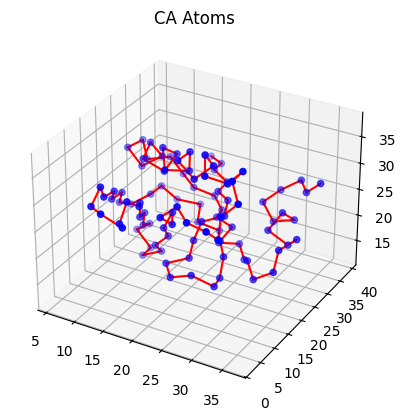

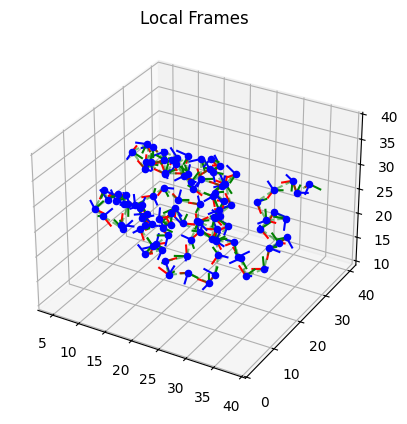

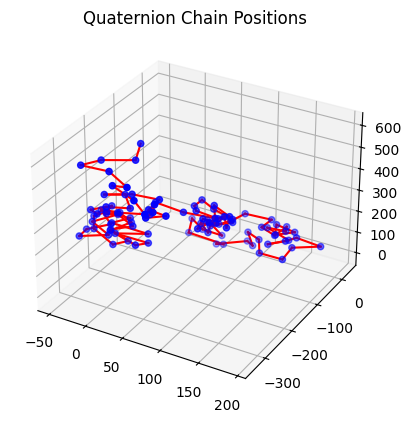

In [17]:
# Plot CA coordinates
ca_coords = pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="CA")
plot_points(ca_coords, "CA Atoms")

# Plot frames (R, T)
plot_transforms(R_true, t_true, "Local Frames")

# Plot global positions from quaternion chain
plot_quaternion_chain(quaternions, t_true, "Quaternion Chain Positions")

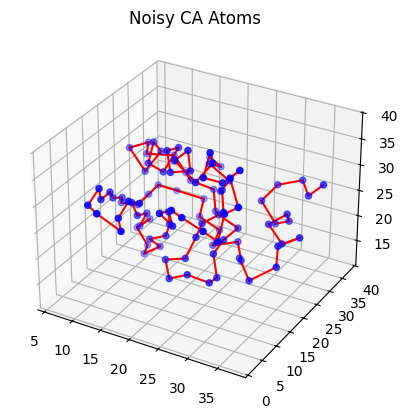

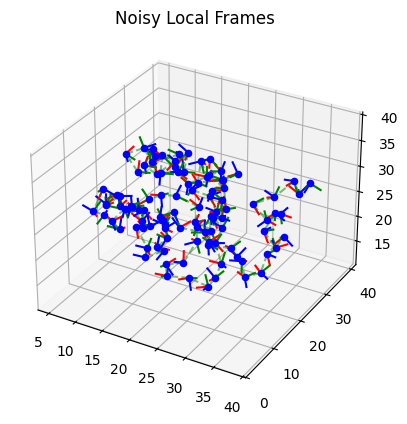

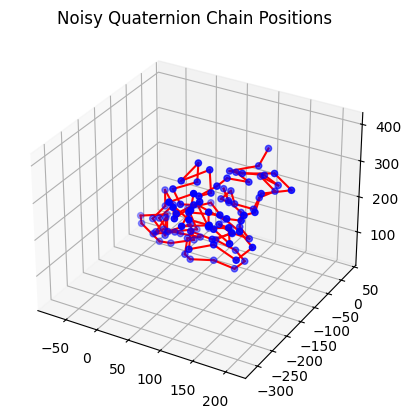

FAPE loss (noisy vs. true): 7.502575874328613


RuntimeError: The size of tensor a (103) must match the size of tensor b (3) at non-singleton dimension 2

In [18]:
# Add noise to the coordinates
noise_level = 0.5  # adjust as needed
coords_noisy = coords + torch.randn_like(coords) * noise_level

# Recompute R and T for noisy coordinates
R_noisy, t_noisy = pdb2pyg.compute_local_frame(coords_noisy)

# Convert noisy R to quaternions
quaternions_noisy = rotation_matrix_to_quaternion(R_noisy)

# Plot noisy CA coordinates
ca_coords_noisy = pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="CA") + torch.randn_like(ca_coords) * noise_level
plot_points(ca_coords_noisy, "Noisy CA Atoms")

# Plot noisy frames
plot_transforms(R_noisy, t_noisy, "Noisy Local Frames")

# Plot noisy quaternion chain
plot_quaternion_chain(quaternions_noisy, t_noisy, "Noisy Quaternion Chain Positions")

# --- Compute FAPE loss and lDDT loss ---
from src.losses.losses import fape_loss, lddt_loss

# FAPE loss (using original as true, noisy as pred)
batch = torch.zeros(coords.shape[0], dtype=torch.long)  # single batch
fape = fape_loss(R_true, t_true, R_noisy, t_noisy, batch)
print("FAPE loss (noisy vs. true):", fape.item())

# lDDT loss (using original as true, noisy as pred)
lddt = lddt_loss(ca_coords, R_noisy, t_noisy, batch)
print("lDDT loss (noisy vs. true):", lddt.item())

In [ ]:
# Plot original and noisy CA coordinates together for comparison
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ca_coords[:,0], ca_coords[:,1], ca_coords[:,2], c='b', label='Original CA')
ax.scatter(ca_coords_noisy[:,0], ca_coords_noisy[:,1], ca_coords_noisy[:,2], c='r', alpha=0.6, label='Noisy CA')
ax.set_title("Original vs Noisy CA Atoms")
ax.legend()
plt.show()